## Filtering a Step Response

Simple smoothing does OK with a reasonable choice of time constant.


In [2]:
# Adapted from http://scipy-cookbook.readthedocs.io/items/FIRFilter.html
from numpy import *
from numpy.random import randn
from scipy.signal import *
from pylab import *
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)


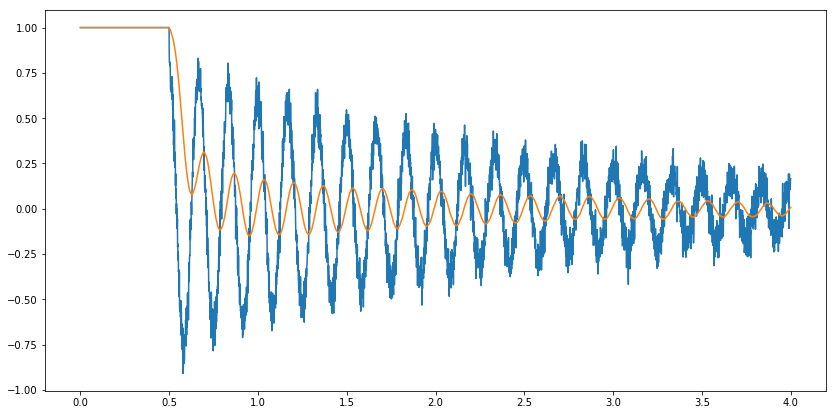

In [3]:
def expSmooth(t,T,tau):        # returns a smoothed version of T with time constant tau
    Ts = T.copy()              # another vector for the smoothed data
    for i in range(1,len(Ts)): # here's where the actual smoothing happens
        dt = t[i]-t[i-1]
        w = min(dt/tau,1)
        Ts[i] = Ts[i-1] * (1-w) + T[i] * w
    return Ts                  # return the smoothed data

#------------------------------------------------
# Create a noisy, decaying, sinusoidal signal for demonstration.
#------------------------------------------------
f = 1000.0
n = 4000.0
tf = linspace(0,n/f,n)
xf = tf.copy()
xf[0:500] = 1
xf[500:] = cos((tf[500:] - tf[500])*2*pi*6)*exp(-tf[500:]/2) + randn(int(n-500))/17

plot(tf,xf)

xs = expSmooth(tf,xf,0.1)
plot(tf,xs)


Subsample the results to reduce the kernel size

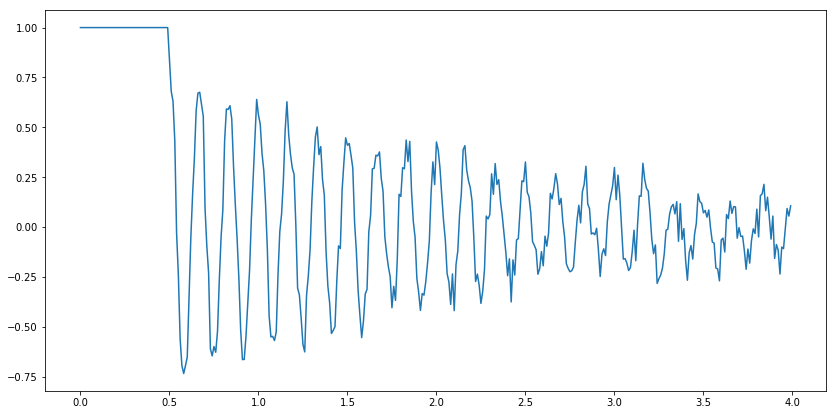

In [4]:
subFactor = 10
sample_rate = f/subFactor
nsamples = int(n/subFactor)
t = zeros(int(nsamples))
x = t.copy()
for i in range(0,int(nsamples)):
    t[i] = tf[int(i*subFactor)]
    x[i] = xf[int(i*subFactor)]
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

plot(t,x)


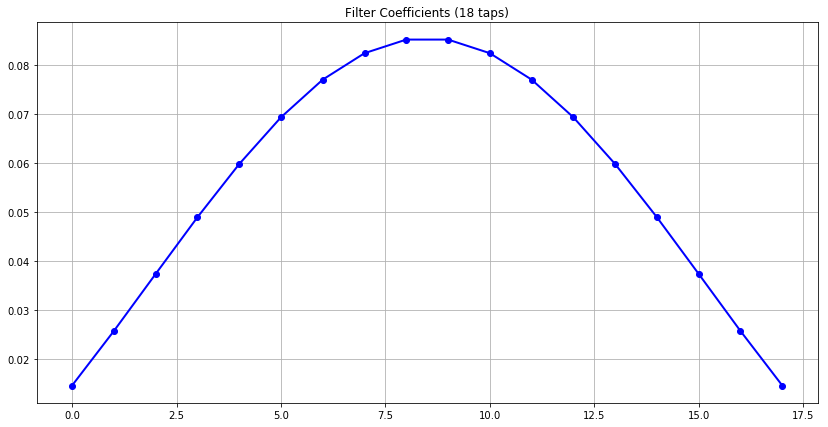

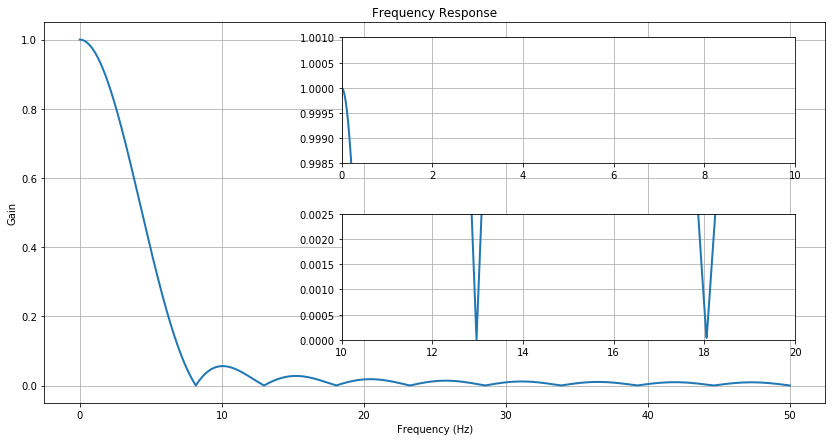

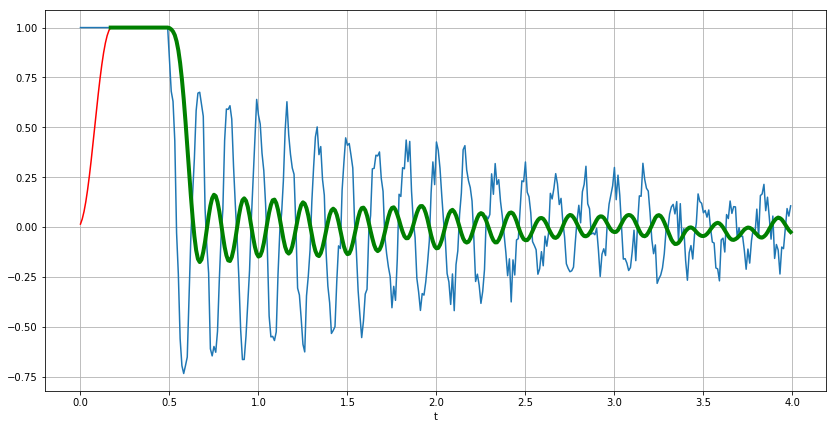

In [5]:



def plotResults():
    #------------------------------------------------
    # Plot the original and filtered signals.
    #------------------------------------------------
    figure(3)
    # Plot the original signal.
    plot(t, x)
    # Plot the filtered signal, shifted to compensate for the phase delay.
    plot(t-delay, filtered_x, 'r-')
    # Plot just the "good" part of the filtered signal.  The first N-1
    # samples are "corrupted" by the initial conditions.
    plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)
    xlabel('t')
    grid(True)

def plotFilterFigs():      # put the polotting in a function so we can play with the effects
    #------------------------------------------------
    # Plot the FIR filter coefficients.
    #------------------------------------------------
    figure(1)
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    #------------------------------------------------
    # Plot the magnitude response of the filter.
    #------------------------------------------------
    figure(2)
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)

    # Upper inset plot.
    ax1 = axes([0.42, 0.6, .45, .25])
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,10.0)
    ylim(0.9985, 1.001)
    grid(True)

    # Lower inset plot
    ax2 = axes([0.42, 0.25, .45, .25])
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(10.0, 20.0)
    ylim(0.0, 0.0025)
    grid(True)

    plotResults()
    show()
    
#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 20.0

# The cutoff frequency of the filter.
cutoff_hz = 5.0

def runFilter():
    global N,beta,taps,filtered_x,delay
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

    # Use lfilter to filter x with the FIR filter.
    filtered_x = lfilter(taps, 1.0, x)

    # The phase delay of the filtered signal.
    delay = 0.5 * (N-1) / sample_rate
    delay = 0

runFilter()
plotFilterFigs()